In [1]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from textwrap import wrap
import networkx as nx
from tqdm import tqdm
import os
from urllib.parse import urlparse, unquote


In [2]:
# url = "https://www.heste-nettet.dk/forum/1/1316128/1316128/"
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"} 



def get_html_content(url, save_dir):
    # Parse the URL to get the path
    parsed_url = urlparse(url)
    # Decode any percent-encoded characters in the path
    path = unquote(parsed_url.path)
    
    # Remove the leading and trailing slashes and replace remaining slashes with underscores
    filename = path.strip('/').replace('/', '_') + '.html'
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define the path for the file
    file_path = os.path.join(save_dir, filename)

    # Check if the file already exists
    if not os.path.isfile(file_path):
        # If not, make a request and save the file
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(response.text)
            soup = BeautifulSoup(response.text, "html.parser")
            return soup
        elif response.status_code in [404, 403]:
            print(f"Response code: {response.status_code} for {url}")
        else:
            return None
    else:
        # If the file exists, read it from the disk
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        soup = BeautifulSoup(content, "html.parser")
        return soup



In [3]:
# def rename_files(directory):
#     for filename in os.listdir(directory):
#         if filename.endswith('.html'):  # Ensure we're only renaming HTML files
#             new_name = f"forum_1_{filename}"
#             old_path = os.path.join(directory, filename)
#             new_path = os.path.join(directory, new_name)
#             os.rename(old_path, new_path)
#             print(f"Renamed '{filename}' to '{new_name}'")

# # Replace 'path/to/your/directory' with the actual path to your directory
# directory_path = './html_scrape - Copy/'
# rename_files(directory_path)

In [3]:

def author_text_scrape(soup):
    author_list = []
    text_list = []
    # Find all the <td> elements with class "light" and itemprop="text"
    td_elements = soup.find_all('td', bgcolor='#787878', valign='top')

    # Iterate through the <td> elements
    for td in td_elements:
        # Extract the author's href number
        author_a = td.find('a', itemprop='url')
        if author_a:
            author_href = author_a['href']
            author_text = author_a.text
            
        else:
            author_href = None
            author_text = td.find('span', itemprop='name').text
        # print(author_text)
        # Find the first <div> with class "rsPost" within the current <td>
        rs_post = td.find('div', class_='rsPost')
        
        if rs_post:
            # Extract Danish text within <span> tags
            danish_text = [span.text for span in rs_post.find_all('p')]
            
            # Combine the text into a single string
            danish_text = "\n".join(danish_text)
                
            # if len(danish_text)>1 and author_text:
                # author_list.append(author_href.split('/')[-2])
            author_list.append(author_text)
            text_list.append(danish_text)
        # if author_text == "Doctor Who" and len(author_list)<2:
        #     print(rs_post)

    return author_list, text_list


In [5]:
# page_links = []
# def get_new_page_link(result):
#     page_links.append(result)
#     soup = get_html_content(f"https://www.heste-nettet.dk{result}")
#     result = soup.find('a', string = 'Ældre indlæg')['href']
#     if result:
#         print(result)
#         get_new_page_link(result)
#     else:
#         return False
# get_new_page_link('/forum/1/')

In [4]:
html_dir = './html_scrape'
href_list = []
for page_index in tqdm(range(70,37100+1,70)): # 185780
    soup = get_html_content(f"https://www.heste-nettet.dk/forum/1/{page_index}/",html_dir)
    post_links = soup.find_all("a",href=True)
    
    # Filter and print the links
    for link in post_links:
        href = link['href']
        if "/forum/1/" in href and len(href.split("/"))==6:
            href_list.append(href)

  0%|          | 0/530 [00:00<?, ?it/s]

100%|██████████| 530/530 [00:13<00:00, 39.65it/s]


In [5]:
len(href_list)

36723

In [6]:
href_list[0]

'/forum/1/2431701/2431701/'

In [7]:
authors_data = []
texts_data = []
used_href_list = []
for href in tqdm(href_list):
    url = f"https://www.heste-nettet.dk{href}"
    if (soup:=get_html_content(url,html_dir)):
        author_list, text_list = author_text_scrape(soup)
        if len(author_list)>0 and len(text_list)>0:
            authors_data.append(author_list)
            texts_data.append(text_list)
            used_href_list.append(href)

100%|██████████| 36723/36723 [18:18<00:00, 33.44it/s]


In [8]:
# Initialize a directed graph (DiGraph)
G = nx.DiGraph()

# Initialize a dictionary to store text lengths for each author
author_text_lengths = {}

# Keep track of added nodes
added_nodes = set()

# Process each webpage
for idx, (authors, text_sections) in enumerate(zip(authors_data, texts_data)):
    # The first author in the inner list is the OP author
    try:
        op_author = authors[0]
    except:
        print(idx, authors, text_sections)
        break
    
    # Add nodes for all authors, including the OP, and initialize the "OP_author" attribute to 0
    for author in authors:
        if author not in added_nodes:
            G.add_node(author, OP_author=0, reads=0,comments = 0)
            added_nodes.add(author)

    # Update the "OP_author" attribute for the OP author
    G.nodes[op_author]["OP_author"] += 1
    G.nodes[op_author]["reads"] += len(authors)-1

    # Connect the OP author to all other authors with weighted edges
    for author in authors[1:]:
        if G.has_edge(author, op_author):
            G[author][op_author]["weight"] += 1  # Increment the edge weight
        else:
            G.add_edge(author, op_author, weight=1)  # Initialize edge weight to 1
        
        G.nodes[author]["comments"] += 1

    # Calculate text lengths and store in the author_text_lengths dictionary
    for author, text_section in zip(authors, text_sections):
        text_length = len(text_section)
        author_text_lengths[author] = text_length


In [13]:
nx.write_graphml(G,'medium_graph.graphml')

ValueError: All strings must be XML compatible: Unicode or ASCII, no NULL bytes or control characters

In [ ]:
# edge_weights = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
# for (u, v), weight in edge_weights.items():
#     print(f"Weight of edge between node {u} and node {v}: {weight}")

KeyboardInterrupt: 

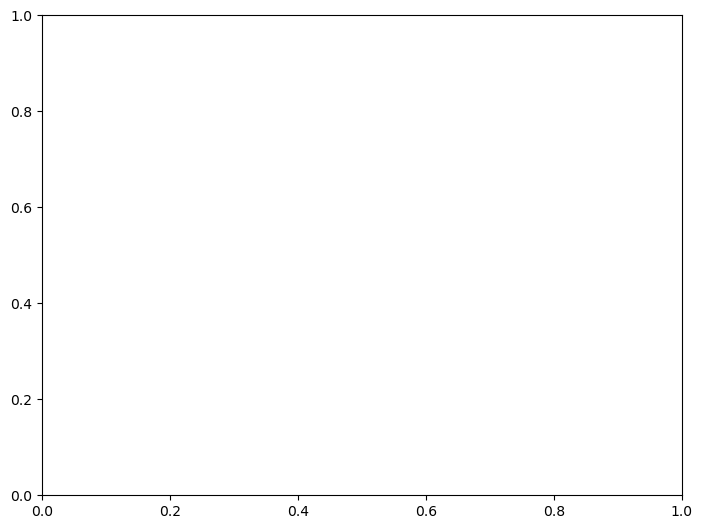

In [9]:
nx.draw(G,node_size=5)


In [ ]:
# sorted(list(dict(G.in_degree).items()),key=lambda x: x[1],reverse=True)
# sorted(list(dict(G.out_degree).items()),key=lambda x: x[1],reverse=True)

In [ ]:
# from pyvis.network import Network

# pyvis_graph = Network(notebook=True,cdn_resources='in_line')
# pyvis_graph.from_nx(G)
# pyvis_graph.show("graph.html")

In [24]:
# Collect edge weights into a list
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

# Normalize edge_weights
max_weight = max(edge_weights)
min_weight = min(edge_weights)
edge_weights_normalized = [(w - min_weight)/(max_weight - min_weight) for w in edge_weights]

# Initialize edge colors
edge_colors = []

for weight in edge_weights_normalized:
    edge_colors.extend([f'rgba(0,0,255,{weight})', f'rgba(0,0,255,{weight})', 'rgba(0,0,0,0)'])


In [25]:
# Layout
pos = nx.spring_layout(G)

# Collect edge weights into a list and normalize them
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)

# Initialize list to store edge traces
edge_traces = []

# Loop through each edge to create an edge trace
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    # Get edge weight and normalize it
    weight = G.edges[edge]['weight']
    normalized_weight = (weight - min_weight) / (max_weight - min_weight)
    
    edge_color = f'rgba(0,0,255,{normalized_weight+0.1})'
    
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=0.5, color=edge_color),
        hoverinfo='none',
        mode='lines'
    )
    
    edge_traces.append(edge_trace)

# Nodes
node_x = []
node_y = []
node_text = []

node_reads = [G.nodes[node].get('reads', 0) for node in G.nodes()]
max_reads = max(node_reads)
min_reads = min(node_reads)
node_sizes = [(reads - min_reads)/(max_reads - min_reads) * 20 + 10 for reads in node_reads]


for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Sample node attributes (Replace this line with your actual node attributes)
    node_text.append(f'Node {node}<br>OP:{G.nodes[node]["OP_author"]}<br>Reads:{G.nodes[node]["reads"]}<br>Comments:{G.nodes[node]["comments"]}')

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    text=node_text,
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_sizes,  # Node sizes based on 'reads'
        colorbar=dict(
            thickness=15,
            title='Node Color Scale',
            xanchor='left',
            titleside='right'
        )
    )
)

# Create the final figure
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.update_layout(
    height=800,
    width=1200
)

fig.show()

KeyboardInterrupt: 

In [12]:
fig.write_html("graph_export_medium.html")

NameError: name 'fig' is not defined

In [14]:
import pandas as pd
# Step 1: Extract node attributes
node_list_with_comments = [(node, data['comments']) for node, data in G.nodes(data=True) if 'comments' in data]

# Step 2: Sort the list by 'comment' attribute
sorted_node_list = sorted(node_list_with_comments, key=lambda x: x[1], reverse=True)

# Step 3: Get the top 10 nodes
top_10_nodes = sorted_node_list[:10]

# Step 4: Create a Pandas DataFrame
df = pd.DataFrame(top_10_nodes, columns=['Node_ID', 'Comment_Count'])

df

,Node_ID,Comment_Count
0,£isbeth (Baloo),5200
1,Sandra ♥Cashew♥,2683
2,Stute,2446
3,123456,2430
4,Paradise »Lost«,2405
5,overskrift,2295
6,Shagya,2244
7,Golda Showers,1957
8,Sif,1917
9,Sophie »Whisper«,1895


In [68]:
import pandas as pd
# Step 1: Extract node attributes
node_list_with_comments = [(node, data['OP_author']) for node, data in G.nodes(data=True) if 'OP_author' in data]

# Step 2: Sort the list by 'comment' attribute
sorted_node_list = sorted(node_list_with_comments, key=lambda x: x[1], reverse=True)

# Step 3: Get the top 10 nodes
top_10_nodes = sorted_node_list[:10]

# Step 4: Create a Pandas DataFrame
df = pd.DataFrame(top_10_nodes, columns=['Node_ID', 'Comment_Count'])

df

,Node_ID,Comment_Count
0,inger christensen,1287
1,Vicky02,911
2,Sandra ♥Cashew♥,544
3,Shagya,436
4,Rollo,421
5,Adian,390
6,camilse,373
7,Christina S,348
8,camilse og Looksen,342
9,Iben ♣Sille-Musen♣,338


In [15]:
sorted(list(dict(G.in_degree).items()),key=lambda x:x[1],reverse=True)[:10]

[('Sandra ♥Cashew♥', 1257),
 ('Shagya', 1252),
 ('Adian', 1199),
 ('Janni (Fleur)', 951),
 ('mik27 ☻Mieke☻', 839),
 ('Mor til ♥Emma♥', 805),
 ('klokkeblomst8 ♥Rose♥', 799),
 ('Tina-Tossen', 717),
 ('Iben ♣Sille-Musen♣', 696),
 ('Gold and Dangerous *Dixie*', 691)]

In [16]:
sorted(list(dict(G.out_degree).items()),key=lambda x:x[1],reverse=True)[:10]

[('£isbeth (Baloo)', 1847),
 ('123456', 1214),
 ('overskrift', 1067),
 ('Sif', 1035),
 ('Sandra ♥Cashew♥', 944),
 ('Adian', 922),
 ('Lenuccia', 836),
 ('Shagya', 808),
 ('Stute', 789),
 ('Sophie »Whisper«', 783)]

In [17]:
G_unD = G.to_undirected()

In [18]:
top_ten = sorted(list(dict(G_unD.degree).items()),key=lambda x:x[1],reverse=True)[:10]



In [19]:
df = pd.DataFrame(top_ten,columns=['user','degree'])
df 

,user,degree
0,£isbeth (Baloo),1923
1,Sandra ♥Cashew♥,1865
2,Adian,1827
3,Shagya,1775
4,tije *Fylkir*,1251
5,123456,1214
6,Sif,1182
7,klokkeblomst8 ♥Rose♥,1166
8,Praxis,1150
9,Janni (Fleur),1129


In [20]:
df['comments'] = df['user'].map(lambda x: G.nodes[x]['comments'])


In [21]:
df

,user,degree,comments
0,£isbeth (Baloo),1923,5200
1,Sandra ♥Cashew♥,1865,2683
2,Adian,1827,1818
3,Shagya,1775,2244
4,tije *Fylkir*,1251,1571
5,123456,1214,2430
6,Sif,1182,1917
7,klokkeblomst8 ♥Rose♥,1166,1597
8,Praxis,1150,1356
9,Janni (Fleur),1129,1048


In [22]:
len(G.nodes())

41368

In [23]:
len(G_unD.edges)

223601

In [ ]:

Time:
08/11/23 kl 13.00
